# Looking at temporal variability, regionally

You're interested in studying the temporal variability.

**What allows the model to predict daily, month and seasonal variations?**

You're not interested in comparing the two images - (don't think convulutions or cross-correlations but time-series prediction instead)

Instead, you're interested in the temporal variability in each region

i.e look at the time series in these regions

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

In [2]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature 

In [3]:
import scipy

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
# load data and mask

ozone = xr.load_dataset("ozone_prediction_ds.nc")
ozone = ozone.where(ozone.observation>0)

In [6]:
ozone

<xarray.Dataset>
Dimensions:       (lat: 48, lon: 120, time: 460)
Coordinates:
  * time          (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2014-08-31
  * lon           (lon) float64 -180.0 -178.5 -177.0 -175.5 ... -4.5 -3.0 -1.5
  * lat           (lat) float64 0.0 1.5 3.0 4.5 6.0 ... 64.5 66.0 67.5 69.0 70.5
Data variables:
    observation   (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    all_features  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    no_geop       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    no_d2m        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    no_msl        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    no_temp       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    no_ssrd       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    no_sst        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

# Ozone observation

In [7]:
# across all three dims
print(ozone.observation.mean(), "\n \n", ozone.observation.std())

<xarray.DataArray 'observation' ()>
array(44.838398, dtype=float32) 
 
 <xarray.DataArray 'observation' ()>
array(13.28997517)


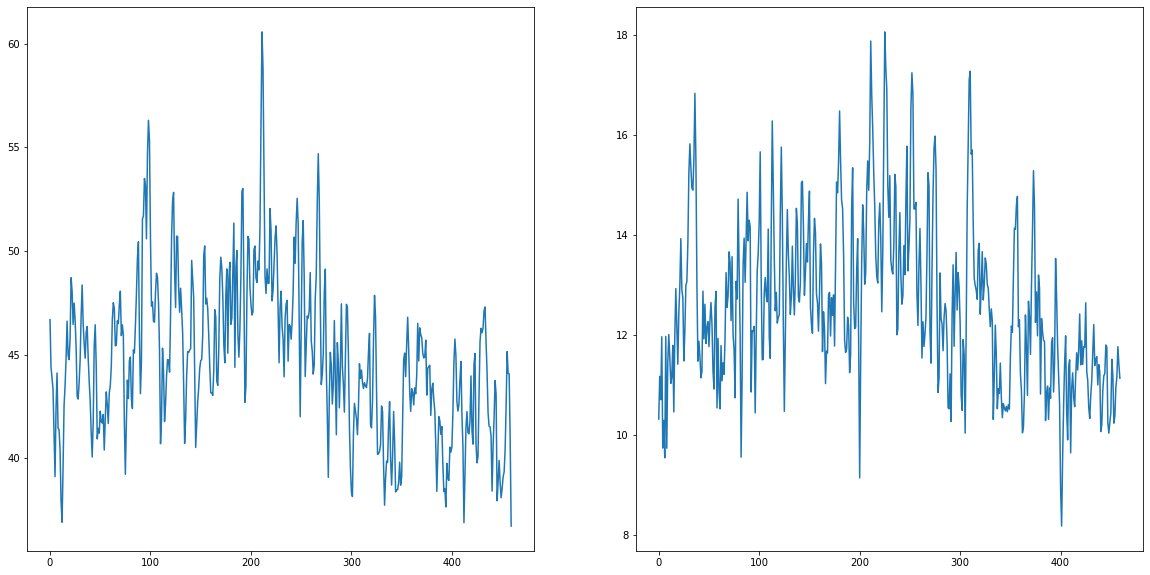

In [81]:
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (20,10))
axs[0].plot(ozone.observation.mean(dim=['lat', 'lon']))
axs[1].plot(ozone.observation.std(dim=['lat', 'lon']))

## Transforming existing axis objects??

You can't change the projection of an existing axes, the reason is given below.

https://stackoverflow.com/questions/33942233/how-do-i-change-matplotlibs-subplot-projection-of-an-existing-axis/34594651#34594651

/Users/apu/miniconda3/envs/DLO3_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


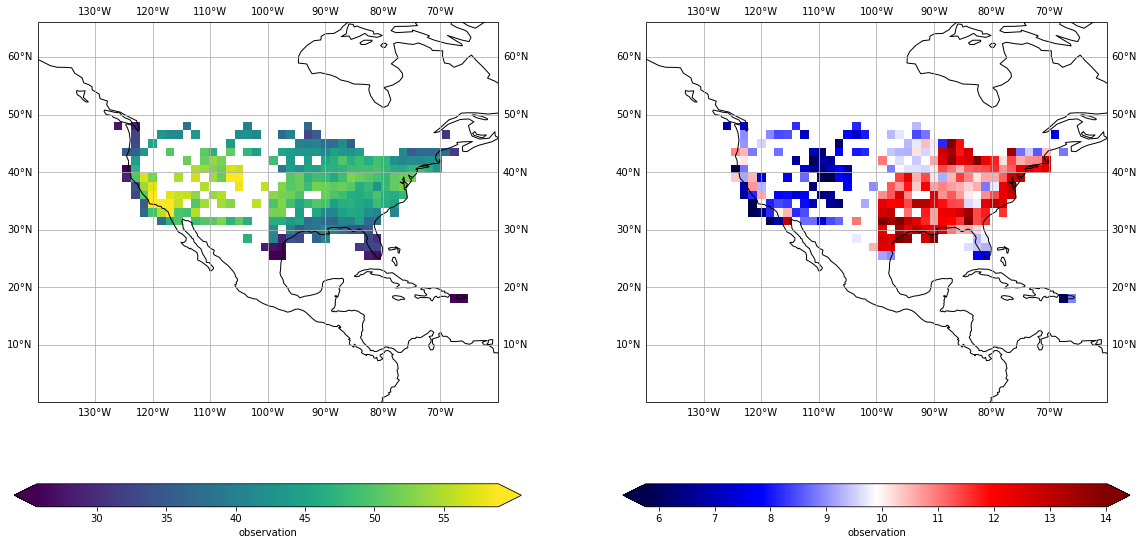

In [29]:
fig, axs = plt.subplots(figsize = (20,10), ncols=2,
                               subplot_kw={'projection': ccrs.PlateCarree()})

# function could set the below in a for loop, when passed a projection axis

# kwargs = {robust=True, # set colorbar limits to 2nd and 98th percentile of data
#           cbar_kwargs={
#             "orientation": "horizontal",
#             "label": "custom label",
#             "pad": 0.2
#           }

ozone.observation.mean(dim=['time']).plot(ax=axs[0], robust = True,
                                          cbar_kwargs = {"orientation" : "horizontal"})
ozone.observation.std(dim=['time']).plot(ax=axs[1], robust = True,
                                          cbar_kwargs = {"orientation" : "horizontal"},
                                        cmap = "seismic")

for ax in axs:    
    ax.set_extent([-140, -60, 0, 60])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True)
    
# plt.savefig("test_observation.png")

# Correlate the time-series at each site (pixel) and then plot those correlations as a heatmap

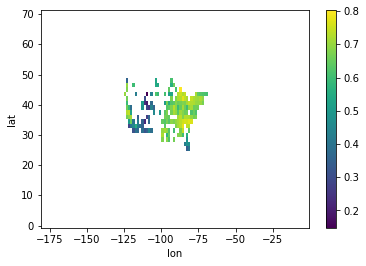

In [6]:
xs.pearson_r(ozone.observation, ozone.all_features, dim='time').plot()

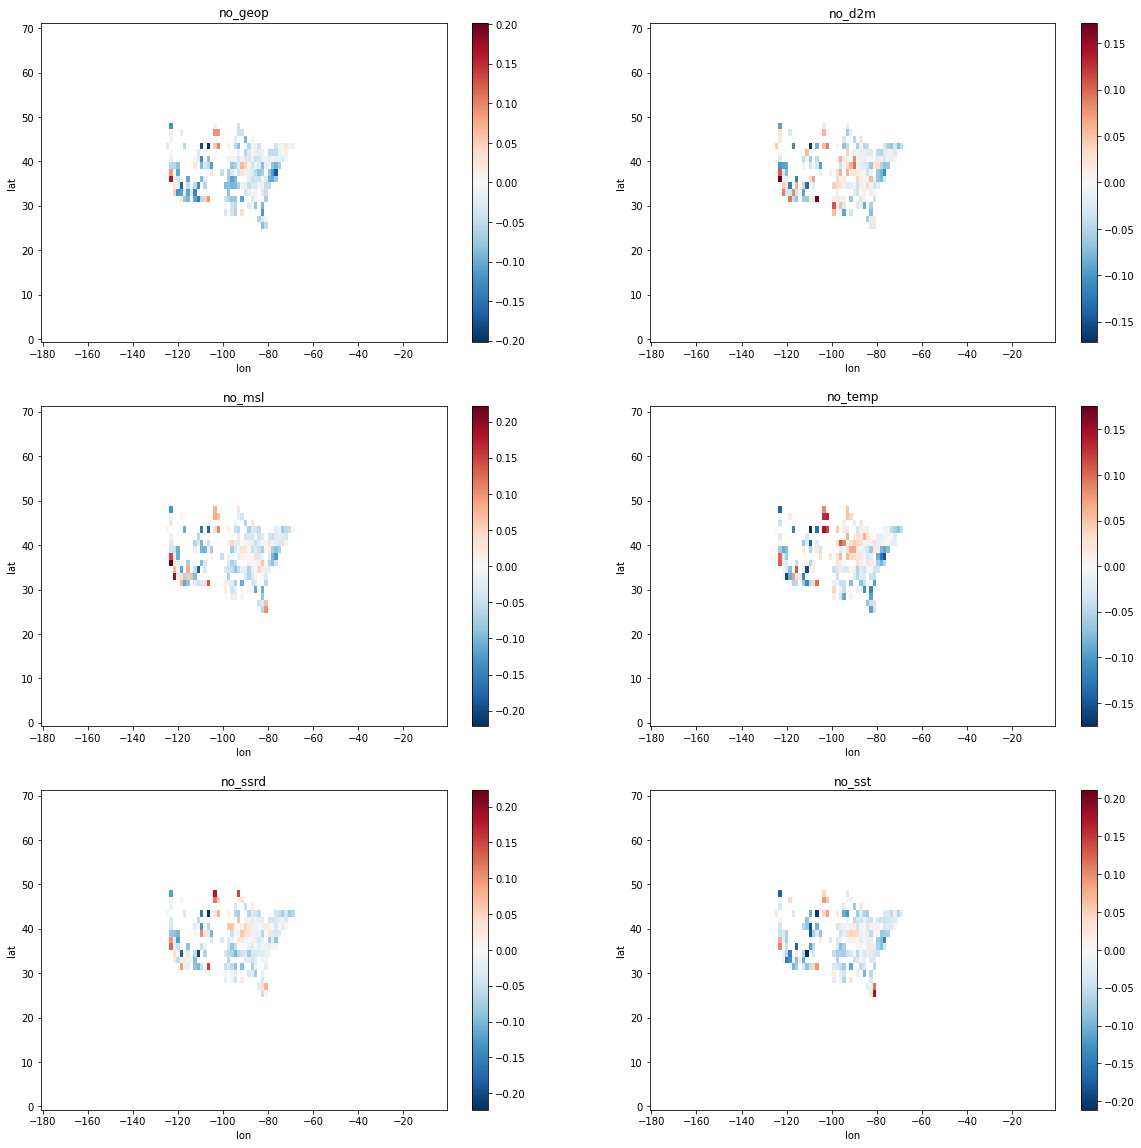

In [7]:
# all correlations with observations
# all differences with the all_features - observation correlation

all_feature_correlation = xs.pearson_r(ozone.observation, ozone.all_features, dim='time')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (20,20))

for idx, var in enumerate(list(ozone.data_vars)[2:]):
    data = getattr(ozone, var)
    corr = xs.pearson_r(ozone.observation, data, dim='time')
    
    # difference to all_correlation
    difference = all_feature_correlation - corr
    
    # plotting
    ax = axs.reshape(-1)[idx]
    difference.plot(ax = ax) 

    ax.set_title(var)
    
# fig.savefig("Difference in correlations")

# Doing the same with numpy

In [8]:
obs = ozone.observation.values
all_features = ozone.all_features.values

In [9]:
corrolation = np.empty_like(obs[0, :, :])

for lat in range(48):
    for lon in range(120):
        corr = np.corrcoef(obs[:, lat, lon], all_features[:, lat, lon])[0,1]
        corrolation[lat, lon] = corr

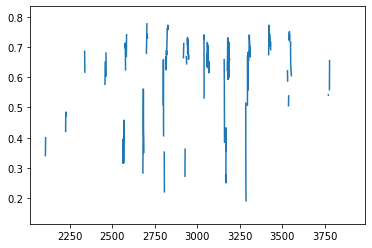

In [10]:
plt.plot(corrolation.flatten())

In [11]:
xs.pearson_r(ozone.observation, ozone.all_features, dim='time').values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

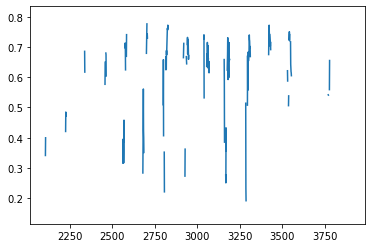

In [12]:
plt.plot((xs.pearson_r(ozone.observation, ozone.all_features, dim='time').values.flatten()))

In [13]:
## difference?

skillscore = xs.pearson_r(ozone.observation, ozone.all_features, dim='time').values

diff = corrolation - skillscore

In [14]:
np.nanmin(diff)

-6.556511e-07

In [15]:
np.nanmax(diff)

7.1525574e-07

# Improving Plots
 - Add coastlines at 110m res
 - Add states


In [16]:
# states =
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name = 'admin_1_states_provinces_shp',
                                      scale = '50m',
                                      facecolor = 'none',
                                      edgecolor = 'black',
                                      linewidth = 0.2
                                     )

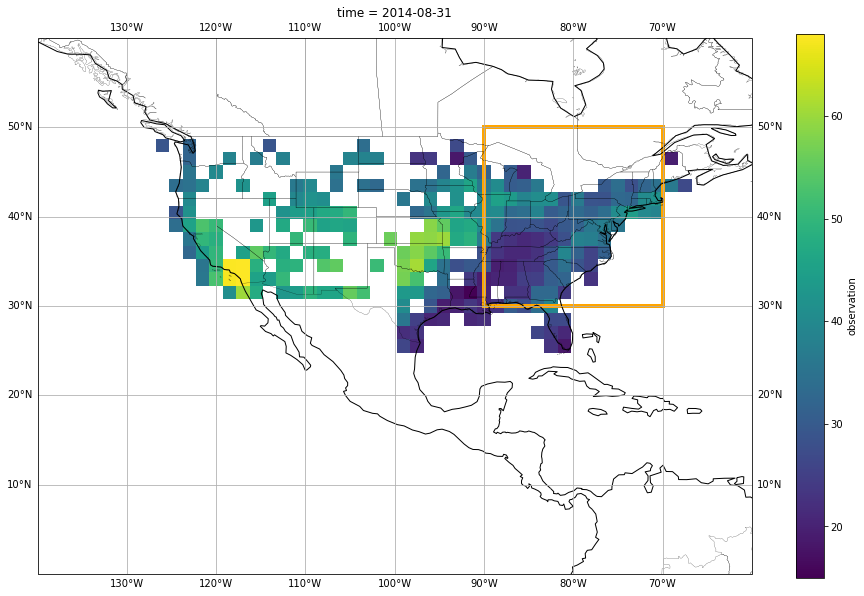

In [17]:
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent((-140, -60, 0, 60), crs = ccrs.PlateCarree())
ax.coastlines('110m')
ax.add_feature(states)
ax.add_patch(mpatches.Rectangle(xy=[-90, 30], width=20, height=20, fill = False,
                                    edgecolor = 'orange', linewidth = 4,
                                    transform=ccrs.PlateCarree()))
ax.gridlines(draw_labels=True)

ozone.observation.isel(time=-1).plot(ax = ax, transform = ccrs.PlateCarree())

In [18]:
# extent = [-140, -60, 0, 60]
# clon = np.mean(extent[:2])
# clat = np.mean(extent[2:])
# proj = ccrs.AlbersEqualArea(clon, clat)

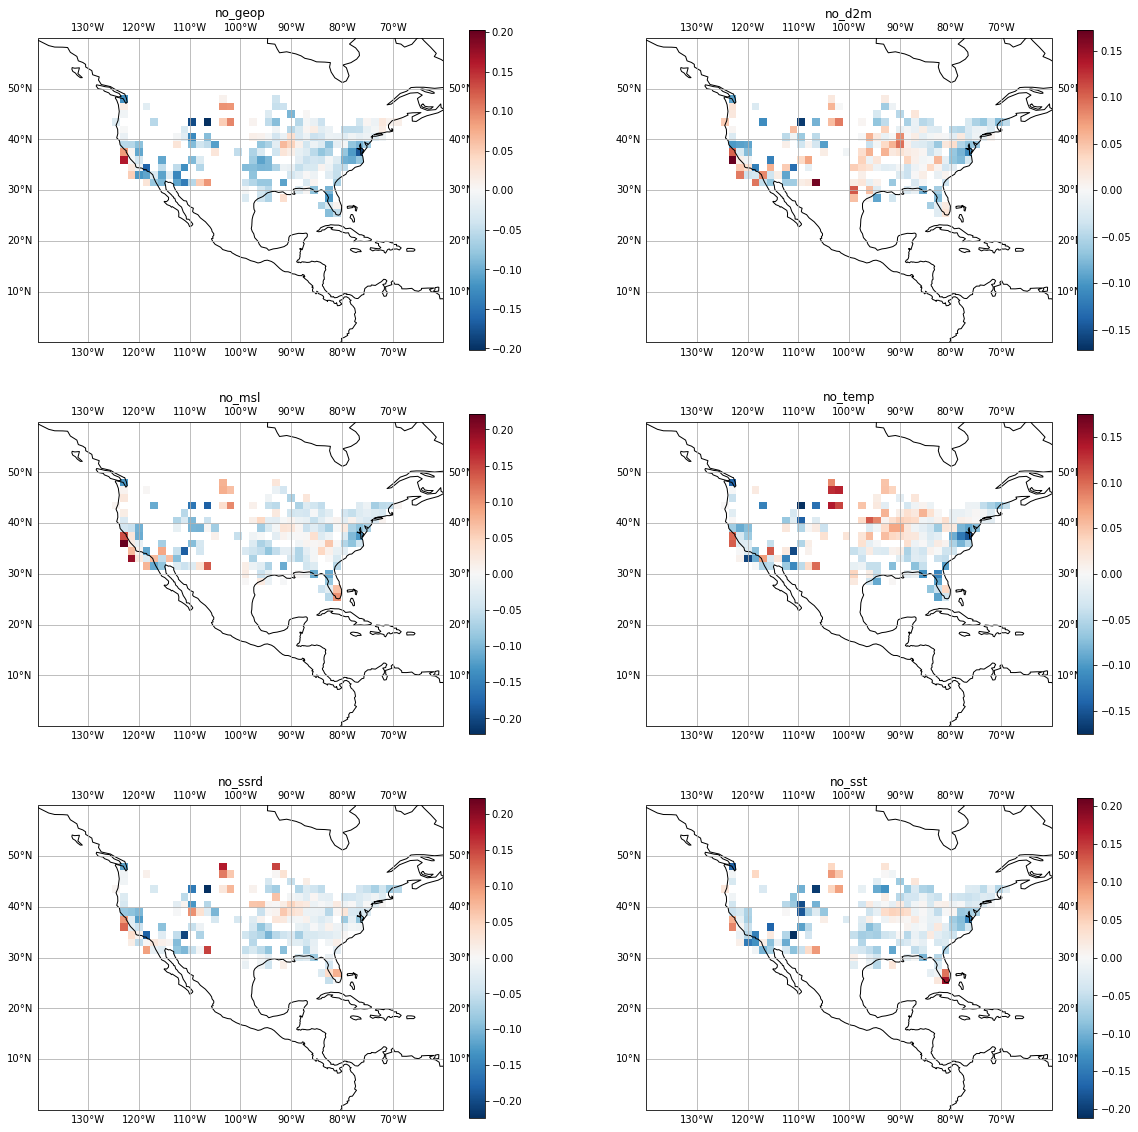

In [19]:
# all correlations with observations
# all differences with the all_features - observation correlation

all_feature_correlation = xs.pearson_r(ozone.observation, ozone.all_features, dim='time')

fig = plt.figure(figsize = (20,20))

# projection of figure
proj = ccrs.PlateCarree()

# form of data 
form = ccrs.PlateCarree()

for idx, var in enumerate(list(ozone.data_vars)[2:]):
    data = getattr(ozone, var)
    corr = xs.pearson_r(ozone.observation, data, dim='time')
    
    # difference to all_correlation
    difference = all_feature_correlation - corr
    
    # plotting
    idx += 1
    ax = plt.subplot(3, 2, idx, projection = proj)
    ax.set_extent((-140, -60, 0, 60), crs = ccrs.PlateCarree())
    ax.coastlines('110m')
#     ax.add_feature(states)
    difference.plot(ax = ax, zorder = 0, transform = ccrs.PlateCarree())
    ax.set_title(var)
    ax.gridlines(draw_labels=True)

# Regional Analysis

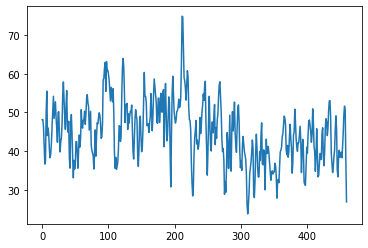

In [20]:
plt.plot(ozone.observation.sel(lon=slice(-90,-80)).sel(lat=slice(30,40)).mean(dim=['lat','lon']))

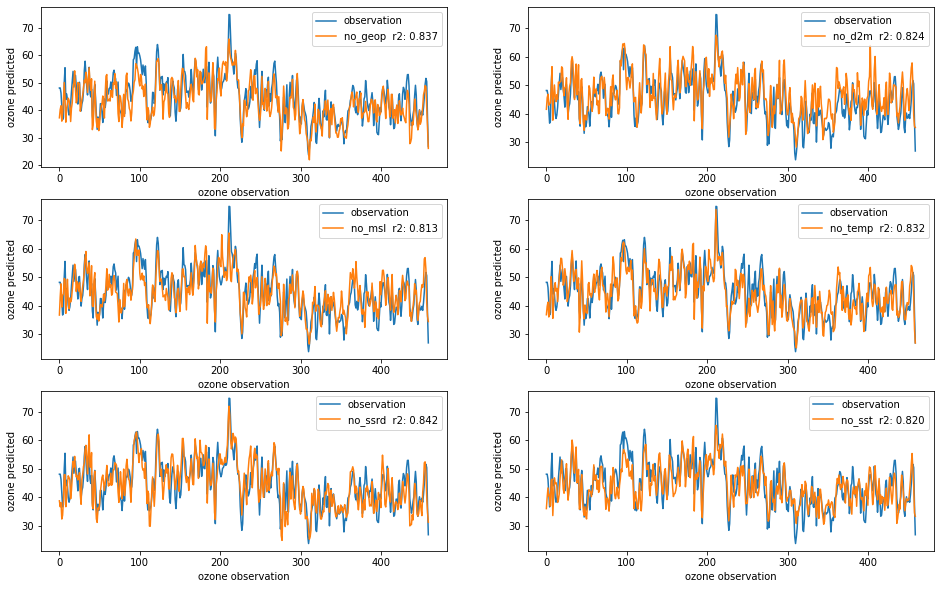

In [21]:
# South East

lons = slice(-90, -80)
lats = slice(30, 40)

obs_series = ozone.observation.sel(lon=lons).sel(lat=lats).mean(('lat', 'lon'))
all_features_series = ozone.all_features.sel(lon=lons).sel(lat=lats).mean(('lat', 'lon'))

fig, axes = plt.subplots(nrows=3, ncols = 2, figsize = (16,10))

for idx, var in enumerate(list(ozone.data_vars)[2:]):
    data = getattr(ozone, var).sel(lon=lons).sel(lat=lats)
    series = data.mean(dim=['lat', 'lon'])
    corr = np.corrcoef(obs_series, series)[0,1]
    
    ax = axes.reshape(-1)[idx]
    ax.plot(obs_series, label = 'observation')
    ax.plot(series, label = var + f'  r2: {corr:.3f}')
    
    ax.set_xlabel('ozone observation')
    ax.set_ylabel('ozone predicted')
    ax.legend()
    
# plt.title("Series")


# Goal:
Do analysis on different regions
Function to plot lat-lon selbox on dataset

In [22]:
import matplotlib.gridspec as gridspec

In [111]:
def plot_region(title: str, lon: list, lat: list) -> None:
    
    if lon == None:
        lon = [-180, 0]
        
    if lat == None:
        lat = [0, 90]
    
    corner = [lon[0], lat[0]]
    w = lon[1] - lon[0]
    h = lat[1] - lat[0]
    
    fig = plt.figure(figsize=(16,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.set_extent((-140, -60, 0, 60), crs = ccrs.PlateCarree())
    ax.coastlines('110m')
    ax.gridlines(draw_labels=True)
    
    ax.add_patch(mpatches.Rectangle(xy=corner, width=w, height=h, fill = False,
                                        edgecolor = 'orange', linewidth = 4,
                                        transform=ccrs.PlateCarree()))

    
    # plot observation average across the years
    ozone.observation.mean(dim='time').plot(ax = ax, transform = ccrs.PlateCarree())
    ax.set_title(title)
    
    # regional time-series analysis
    
    lons = slice(*lon)
    lats = slice(*lat)
    
    obs_series = ozone.observation.sel(lon=lons).sel(lat=lats).mean(('lat', 'lon'))
    all_features_series = ozone.all_features.sel(lon=lons).sel(lat=lats).mean(('lat', 'lon'))

    fig1, axes = plt.subplots(nrows=3, ncols = 2,
                              figsize = (16,10),
                              constrained_layout = False)

    for idx, var in enumerate(list(ozone.data_vars)[2:]):
        data = getattr(ozone, var).sel(lon=lons).sel(lat=lats)
        series = data.mean(dim=['lat', 'lon'])
        corr = np.corrcoef(obs_series, series)[0,1]

        ax = axes.reshape(-1)[idx]
        ax.plot(obs_series, label = 'observation')
        ax.plot(series, label = var + f'  r: {corr:.3f}')
        
        ax.set_title(var)
        ax.set_xlabel('ozone observation')
        ax.set_ylabel('ozone predicted')
        ax.legend()

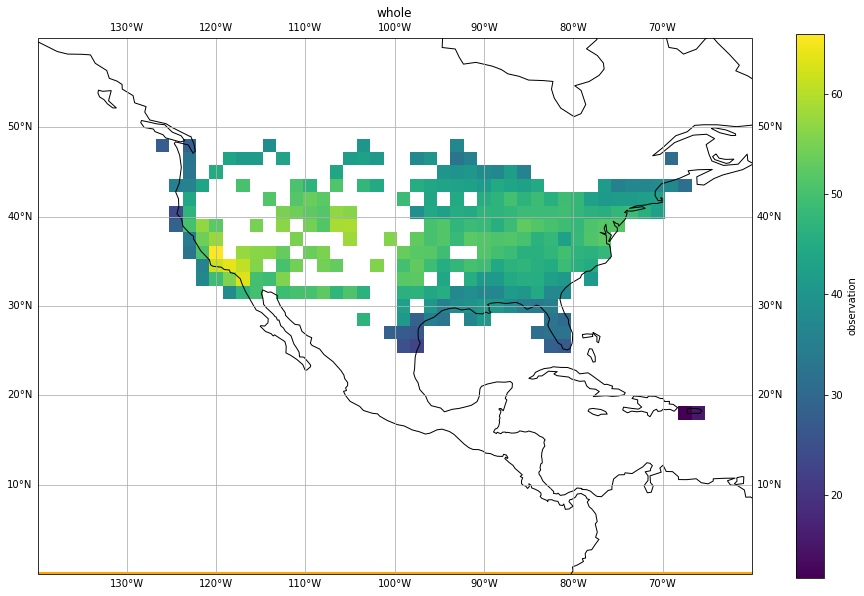

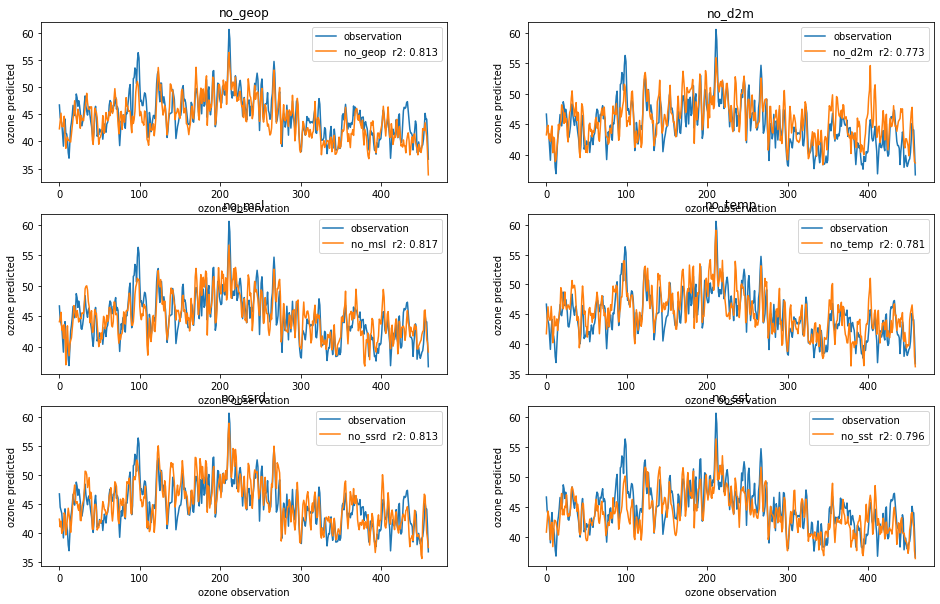

In [24]:
plot_region('whole', lon = None, lat = None )

Number of observations in region:  273


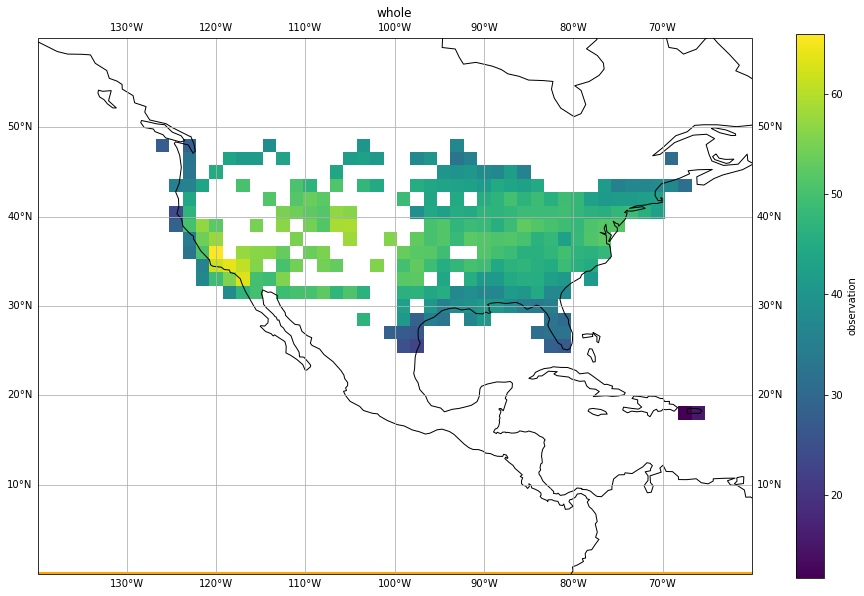

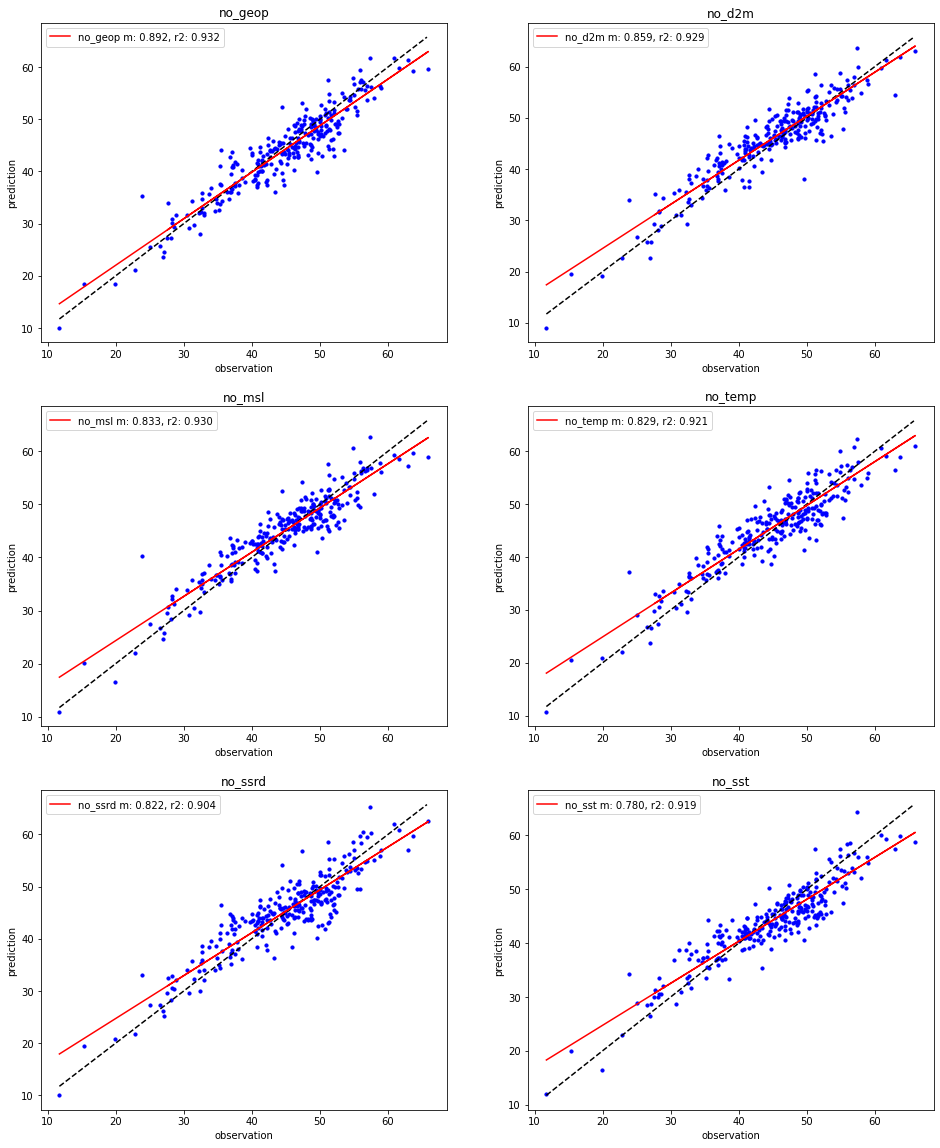

In [198]:
plot_region_scatters("whole", None, None)

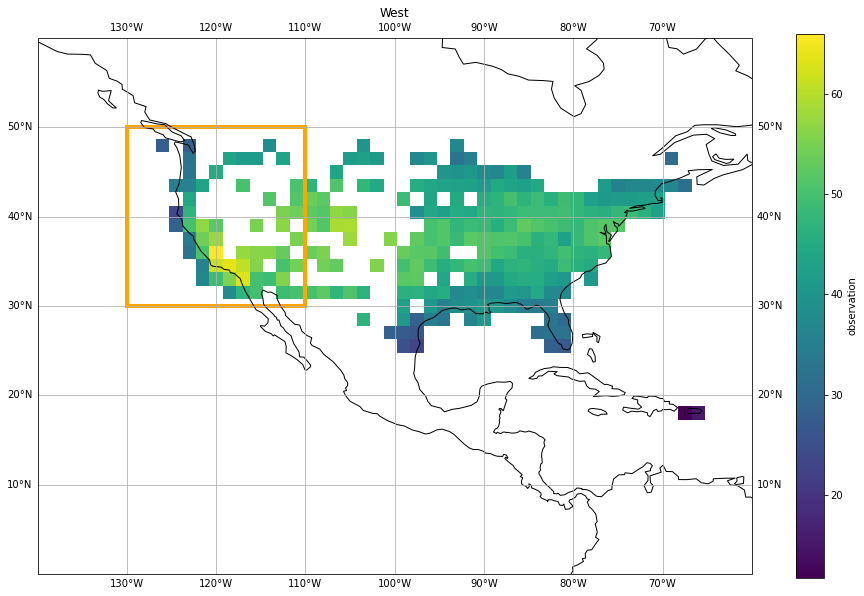

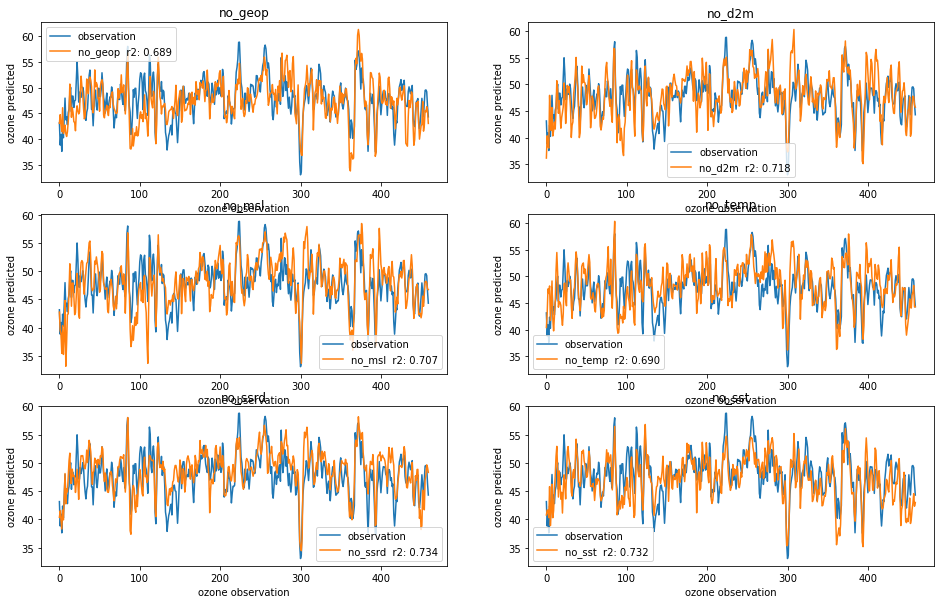

In [25]:
plot_region('West', lon = [-130, -110], lat = [30,50])

Number of observations in region:  58


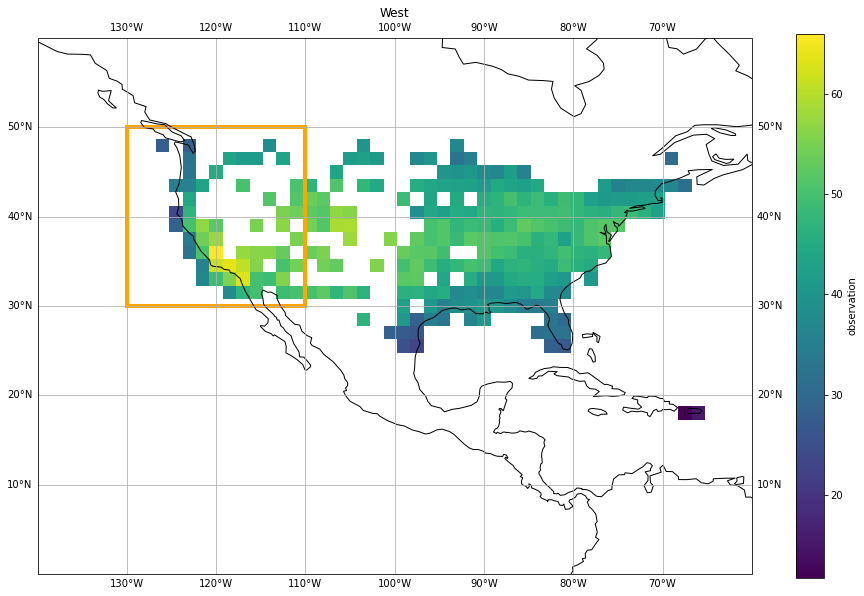

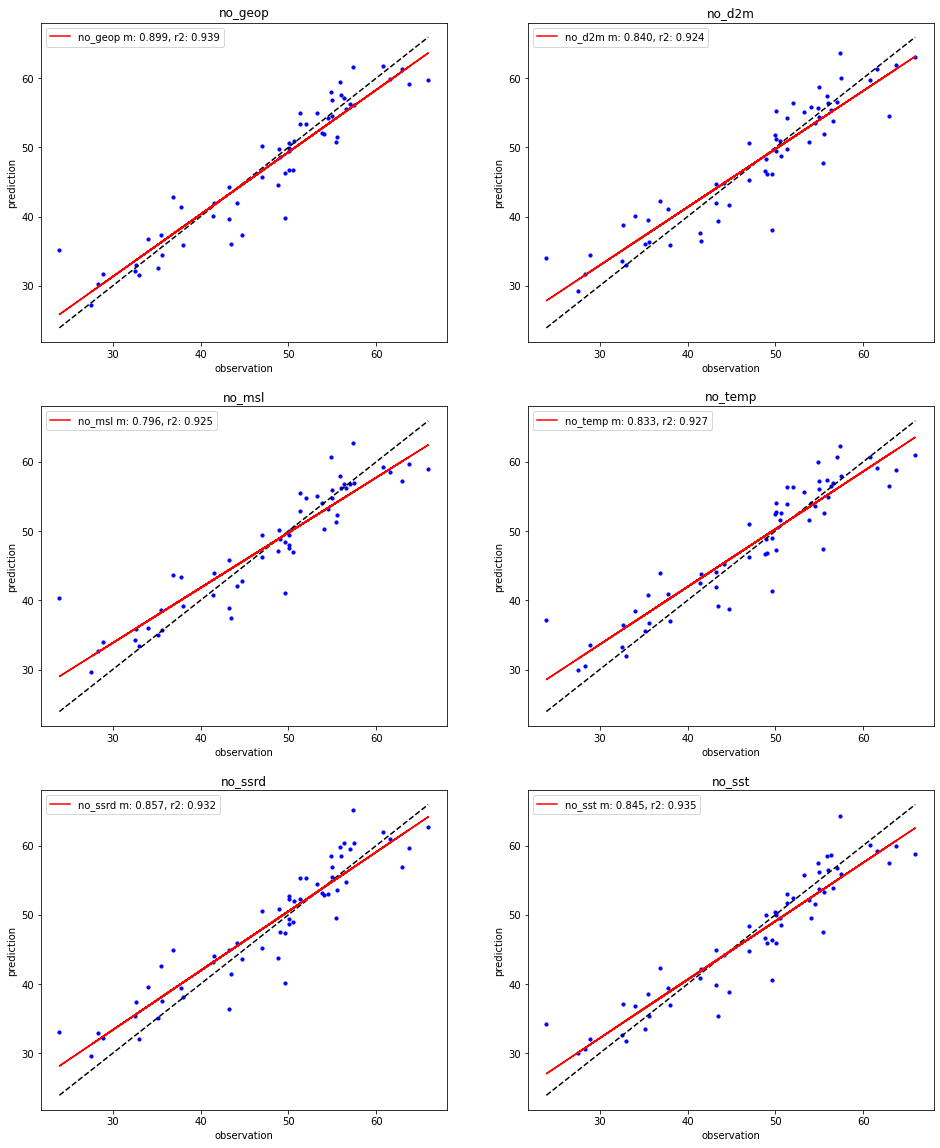

In [12]:
plot_region_scatters('West', lon = [-130, -110], lat = [30,50])

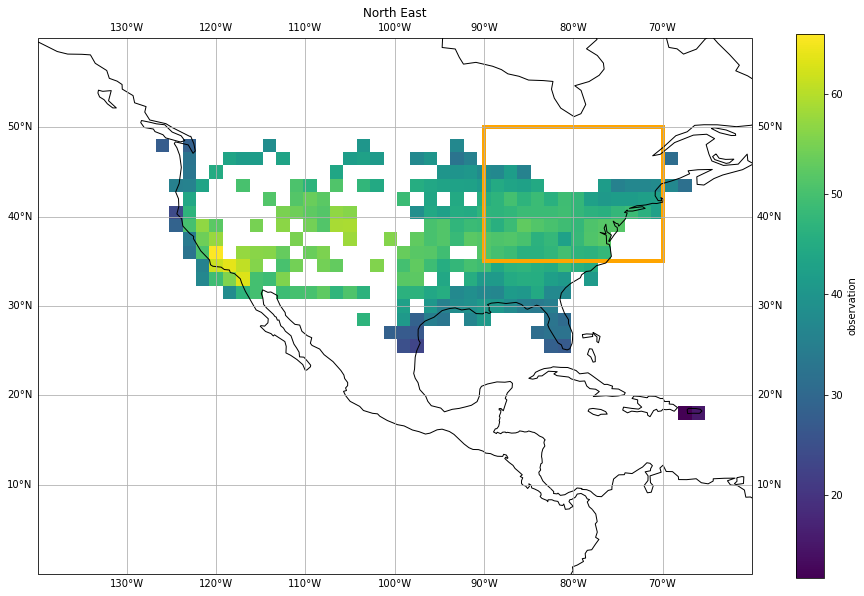

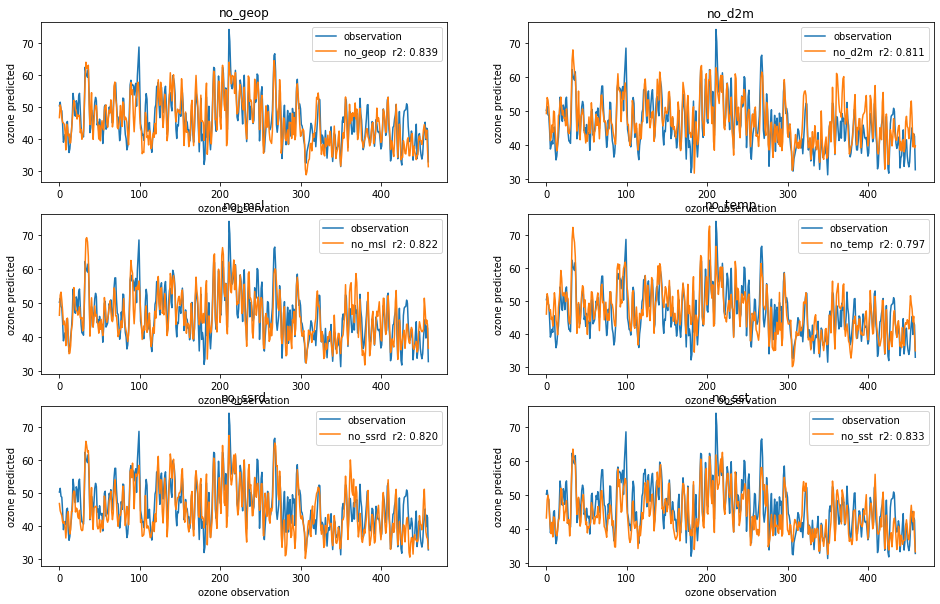

In [26]:
plot_region('North East', lon = [-90, -70], lat = [35,50])

Number of observations in region:  73


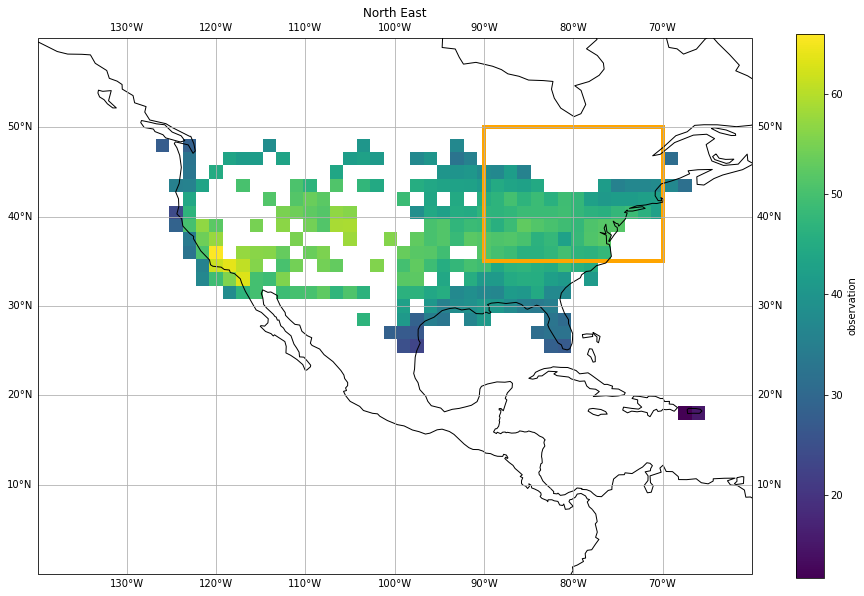

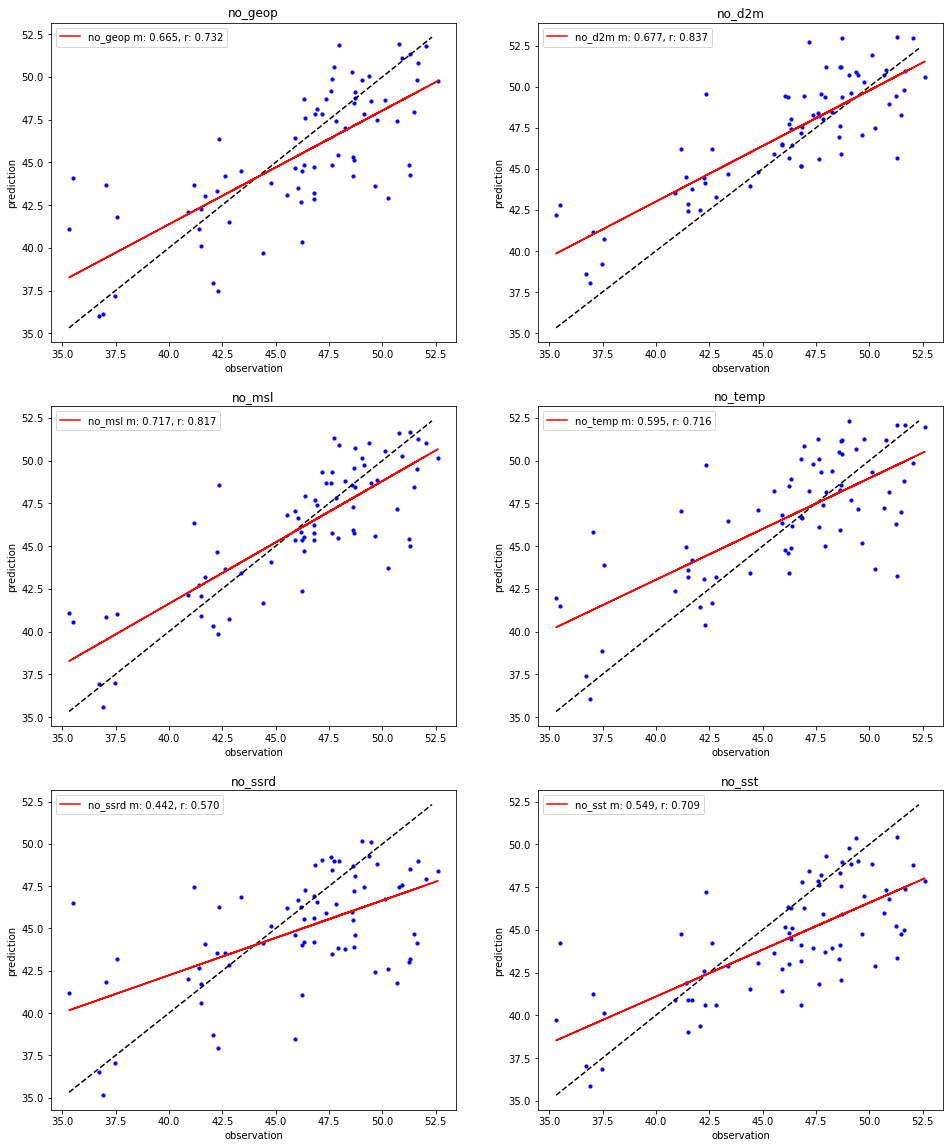

In [14]:
plot_region_scatters('North East', lon = [-90, -70], lat = [35,50])

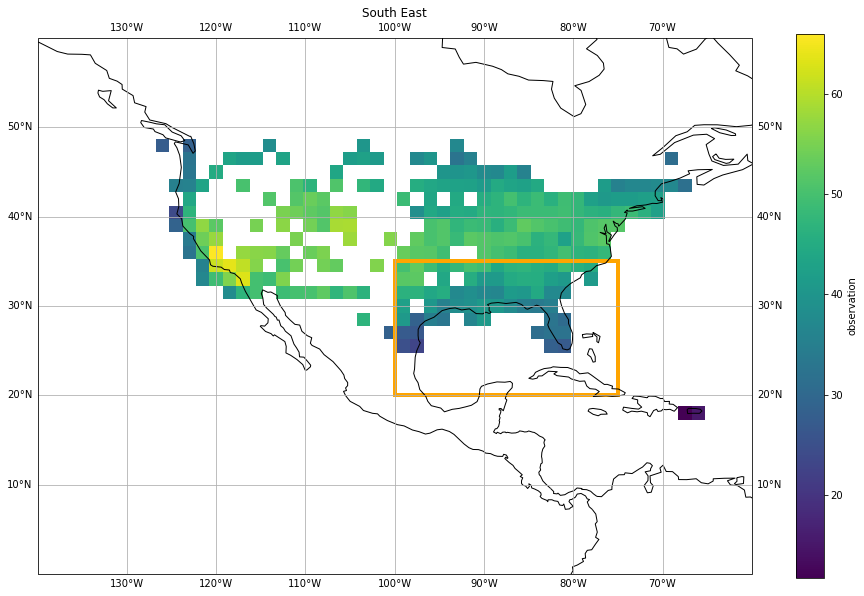

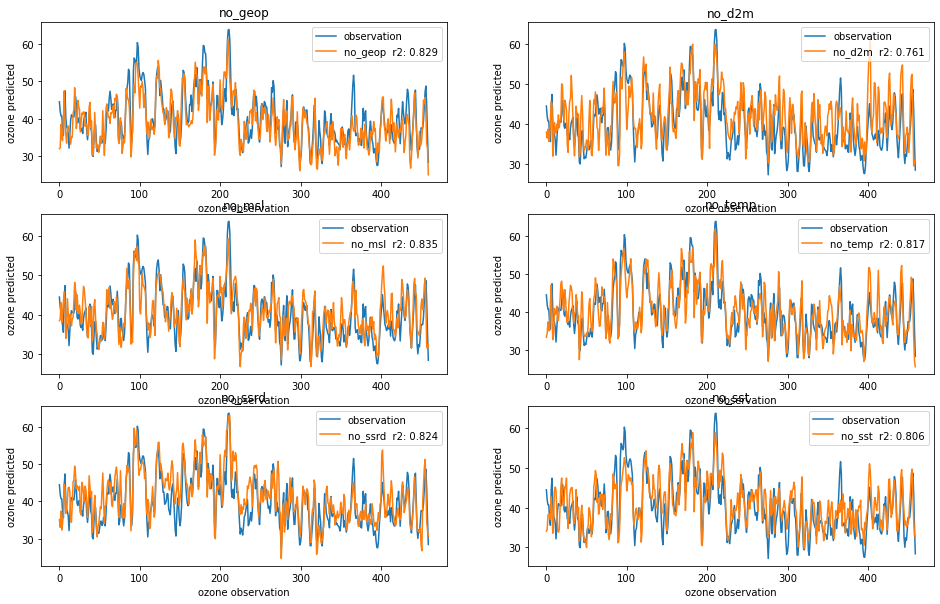

In [27]:
plot_region('South East', lon = [-100, -75], lat = [20,35])

Number of observations in region:  68


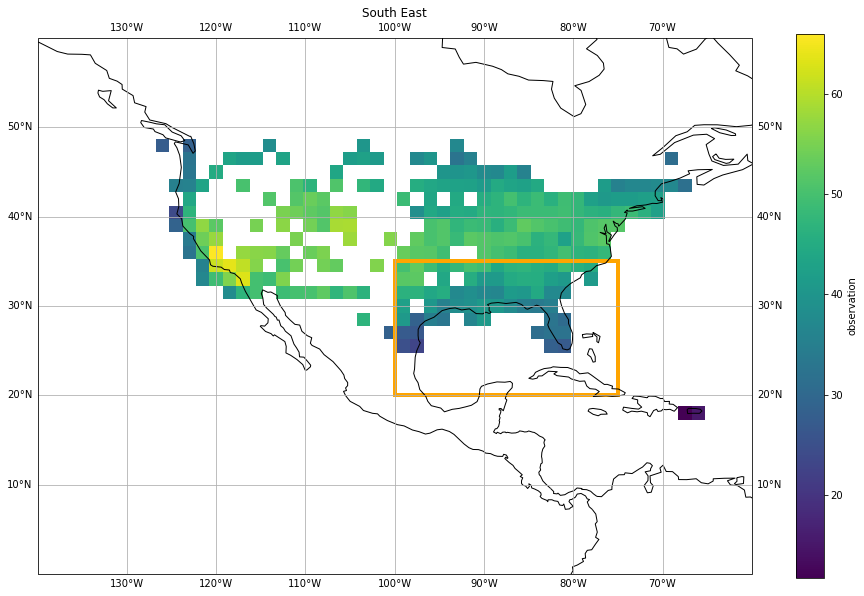

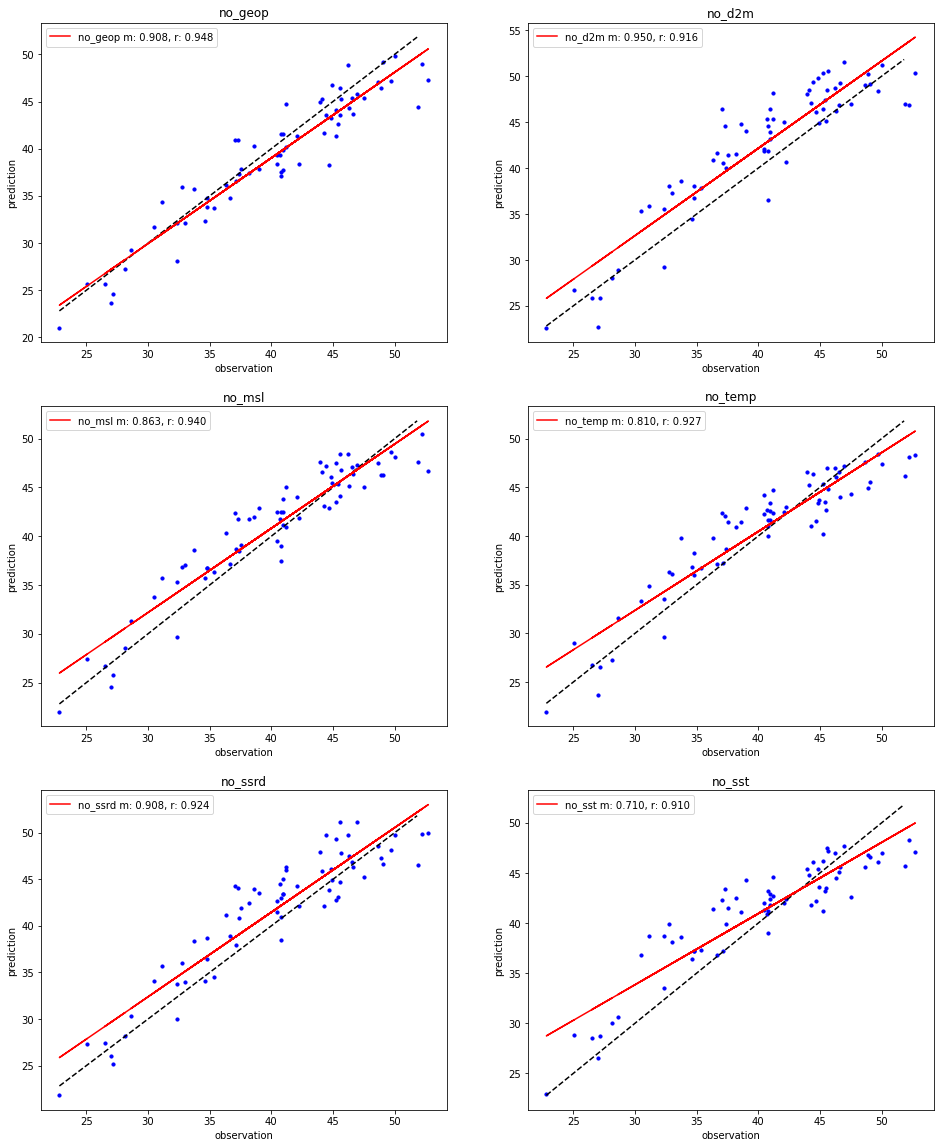

In [15]:
plot_region_scatters('South East', lon = [-100, -75], lat = [20,35])

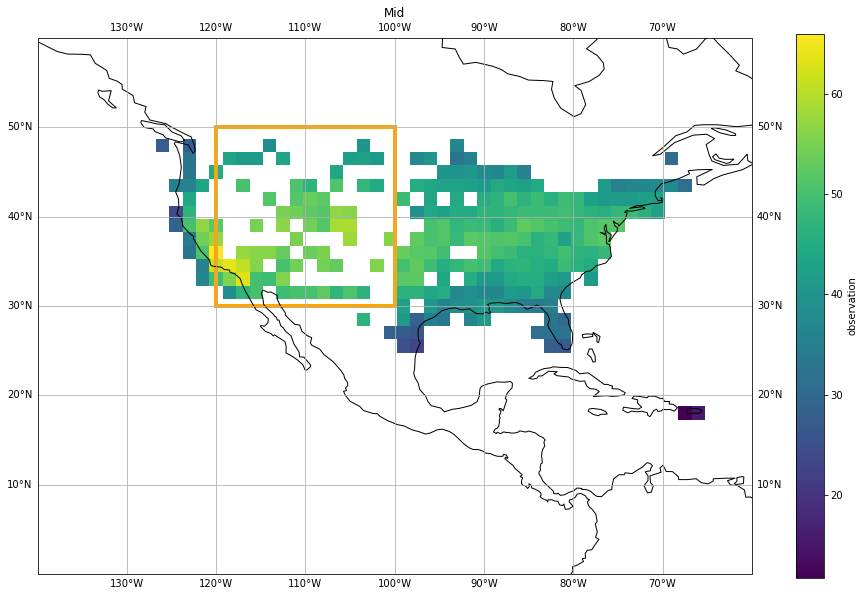

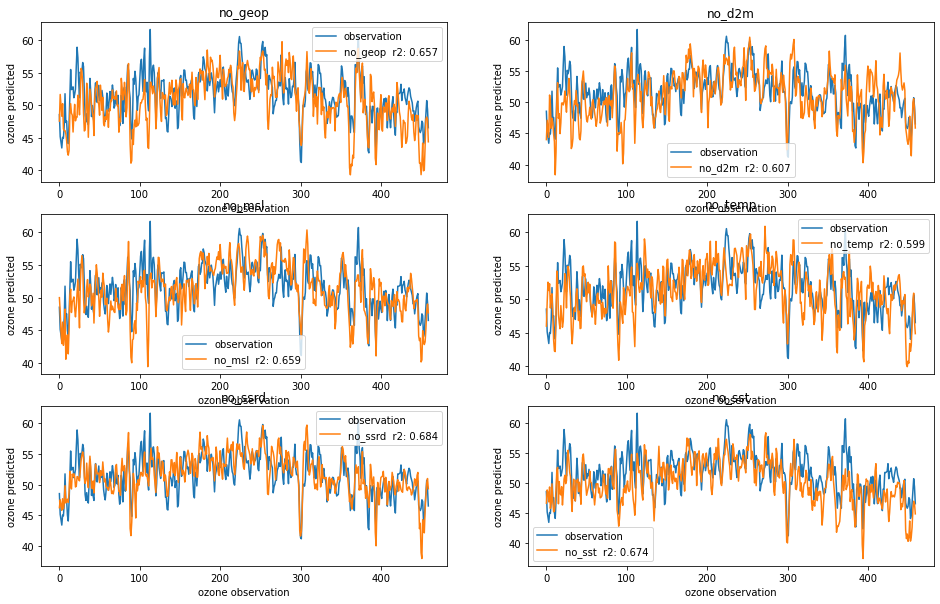

In [28]:
plot_region("Mid", lon=[-120, -100], lat = [30, 50])

Number of observations in region:  70


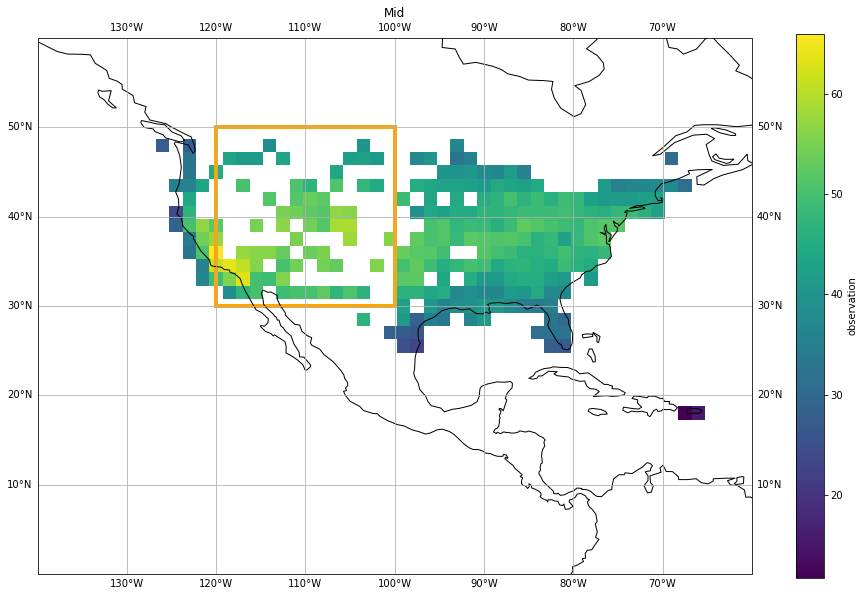

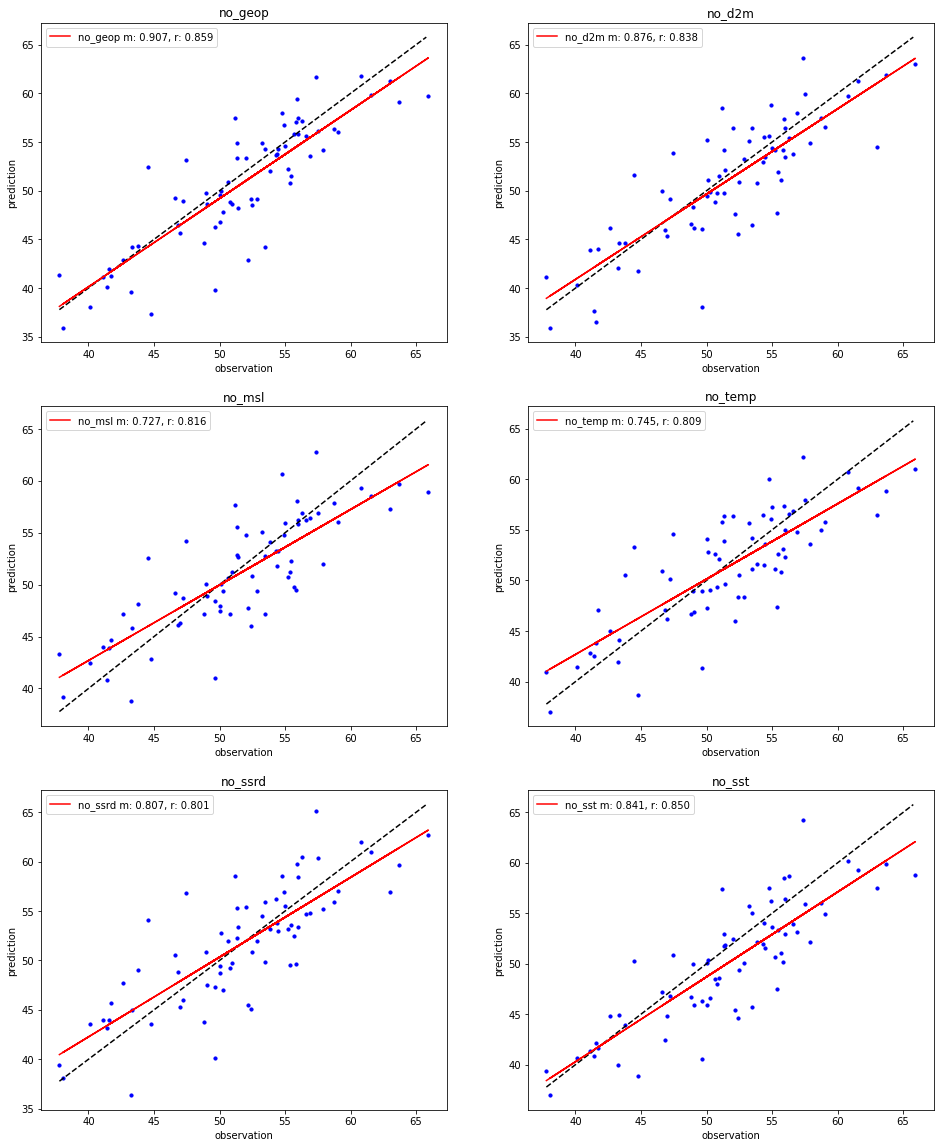

In [34]:
plot_region_scatters("Mid", lon=[-120, -100], lat = [30, 50])

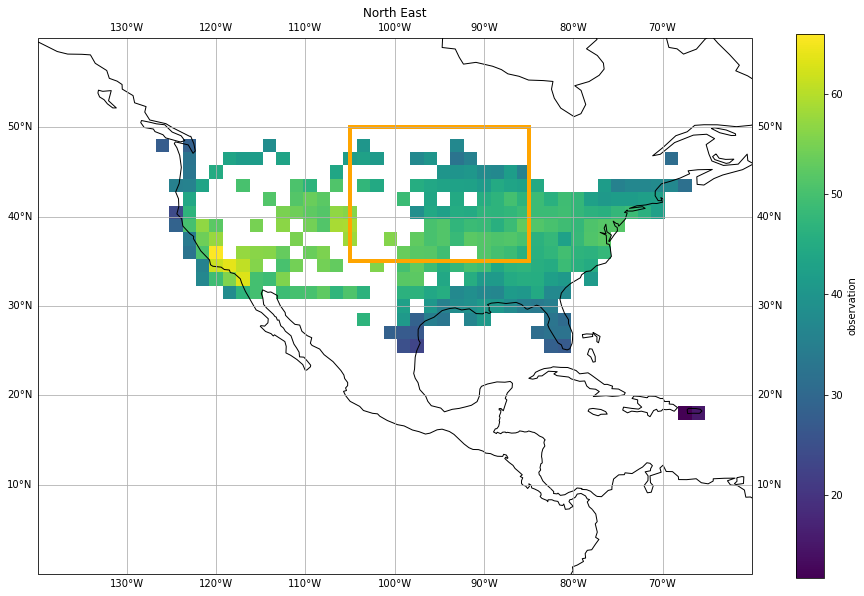

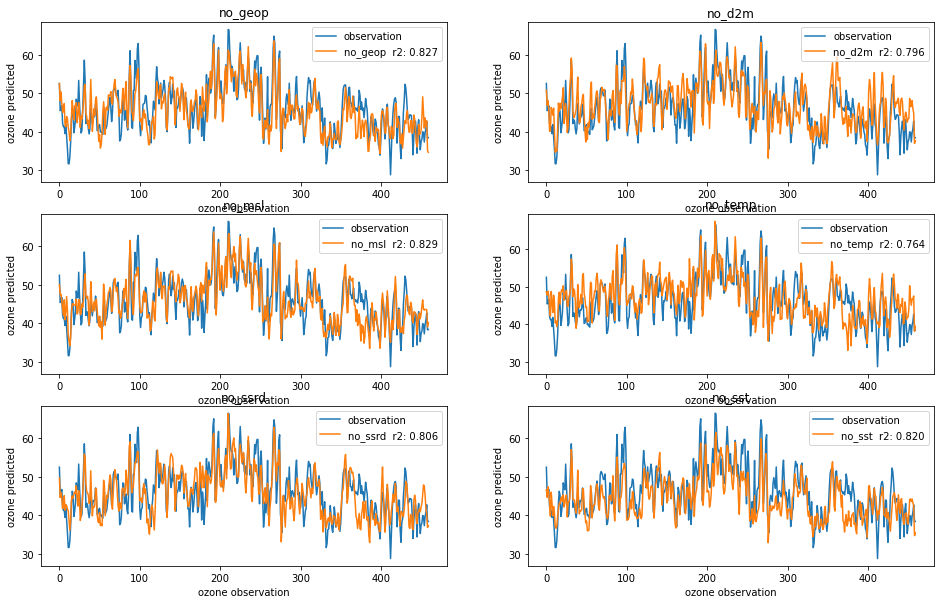

In [114]:
plot_region("North", lon = [-105, -85], lat = [35, 50])

Number of observations in region:  72


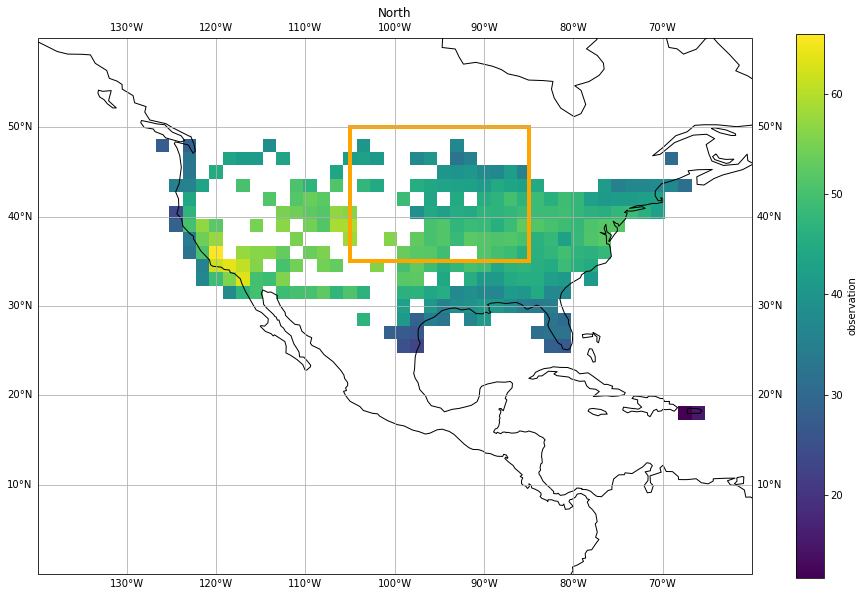

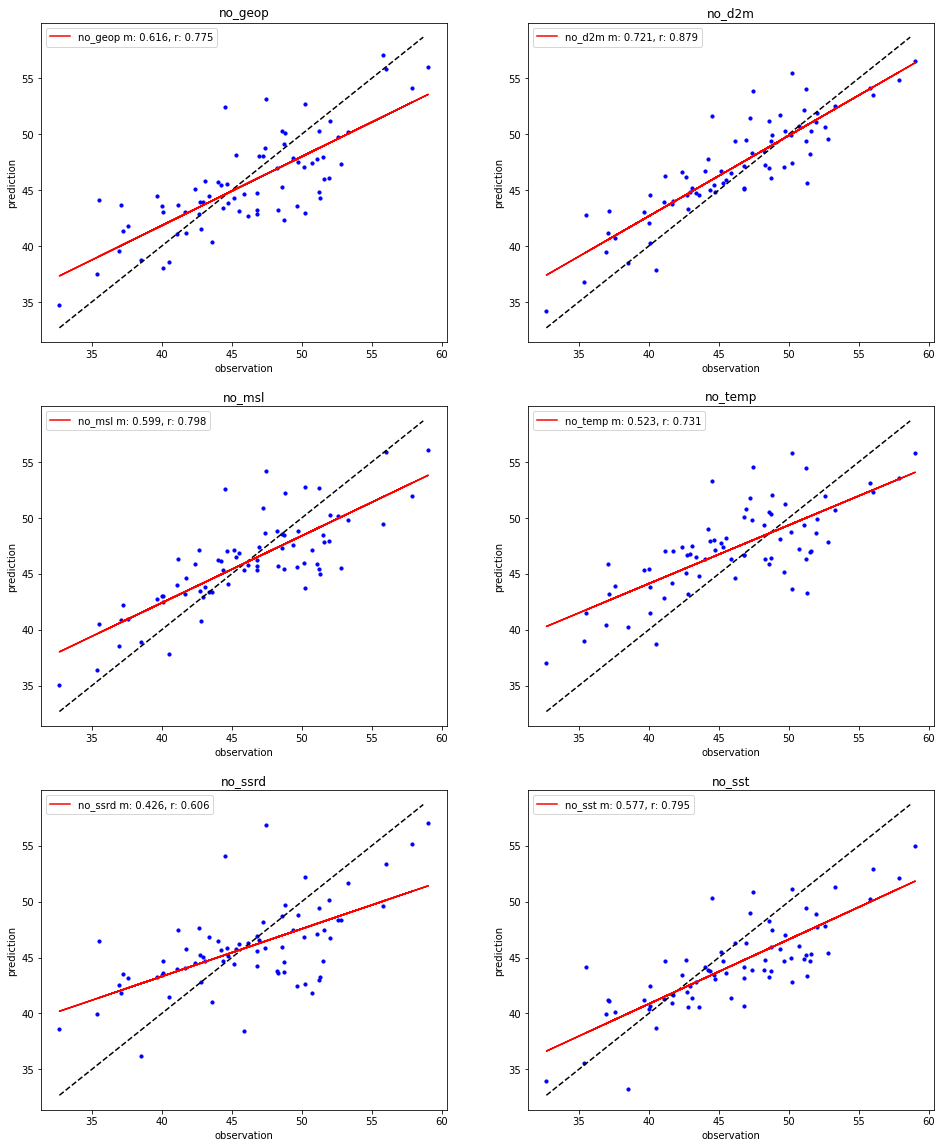

In [35]:
plot_region_scatters("North", lon = [-105, -85], lat = [35, 50])

# Regional Scatters

To look at the bias

Difference and mean time-series

Look at [-115, -85, 35, 50]

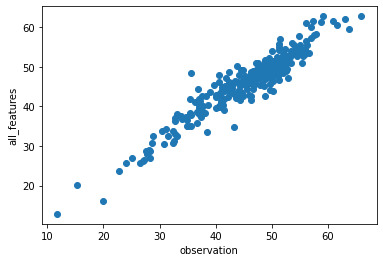

In [119]:
xr.plot.scatter(ozone.mean(dim=['time']), x = 'observation', y = 'all_features' )

In [13]:
def plot_region_scatters(title: str, lon: list, lat: list) -> None:
    
    if lon == None:
        lon = [-180, 0]
        
    if lat == None:
        lat = [0, 90]
    
    corner = [lon[0], lat[0]]
    w = lon[1] - lon[0]
    h = lat[1] - lat[0]
    
    fig = plt.figure(figsize=(16,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.set_extent((-140, -60, 0, 60), crs = ccrs.PlateCarree())
    ax.coastlines('110m')
    ax.gridlines(draw_labels=True)
    
    ax.add_patch(mpatches.Rectangle(xy=corner, width=w, height=h, fill = False,
                                        edgecolor = 'orange', linewidth = 4,
                                        transform=ccrs.PlateCarree()))

    
    # plot observation average across the years
    ozone.observation.mean(dim='time').plot(ax = ax, transform = ccrs.PlateCarree())
    ax.set_title(title)
    
    ####################################################################################
    # regional scatter analysis
    
    lons = slice(*lon)
    lats = slice(*lat)
    
    # meaned-over-time dataset
    ds = ozone.sel(lon=lons).sel(lat=lats).mean(dim=['time'])
    print("Number of observations in region: ", ds.observation.count().item())
    
    
    x_straight = np.arange(ds.observation.min(), ds.observation.max())
    obs_grid = ds.observation
    all_features_grid = ds.all_features

    m_, c_, r_ = fit_attrs(scipy_fit(obs_grid, all_features_grid))
    all_features_fit = m_ * flatten_dataArray(all_features_grid) + c_

    fig, axes = plt.subplots(nrows=3, ncols = 2, figsize = (16,20))

    for idx, var in enumerate(list(ozone.data_vars)[2:]):
        grid = getattr(ds, var)

        # add straight line and predictions
        ax = axes.reshape(-1)[idx]
        ax.plot(x_straight, x_straight, 'k--')
        xr.plot.scatter(ds, x = 'observation', y = var, ax = ax, s = 10, c='b')

        # does the same thing as the scatter above
        # ax.scatter(obs_grid, grid, label = var + " pred", s = 3, c='k')

        # fit and plot
        m, c, r = fit_attrs(scipy_fit(obs_grid, grid))
        fit = m*flatten_dataArray(obs_grid) + c

        ax.plot(flatten_dataArray(obs_grid), fit,
                label=var + " " + f'm: {m:.3f}, r: {r:.3f}', c="r")

        ax.set_title(var)
        ax.set_xlabel('observation')
        ax.set_ylabel('prediction')
        ax.legend()

Number of observations in region:  273


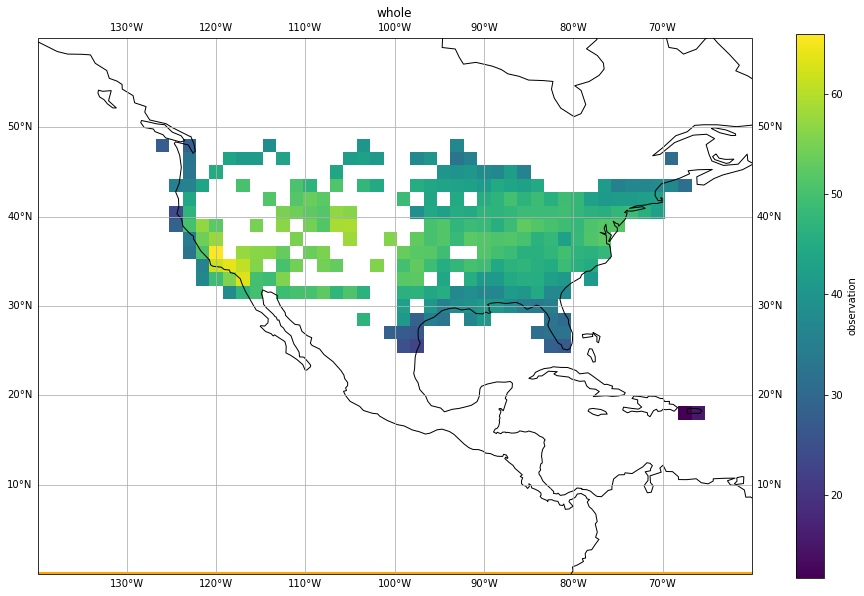

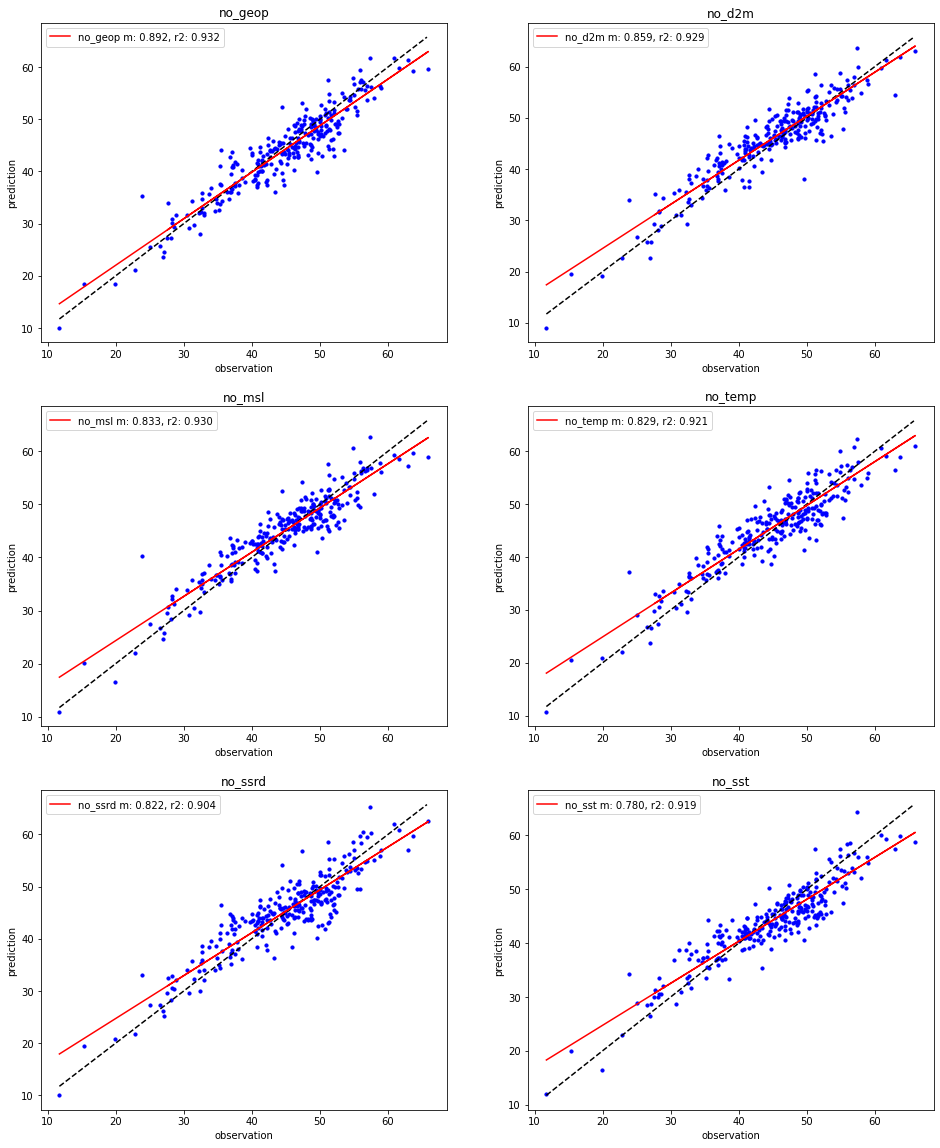

In [198]:
plot_region_scatters("whole", None, None)

Number of observations in region:  72


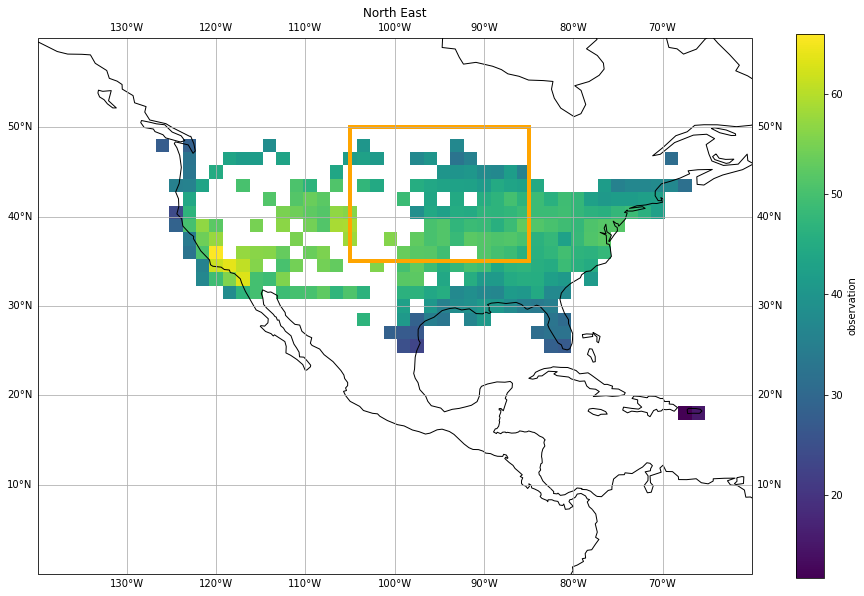

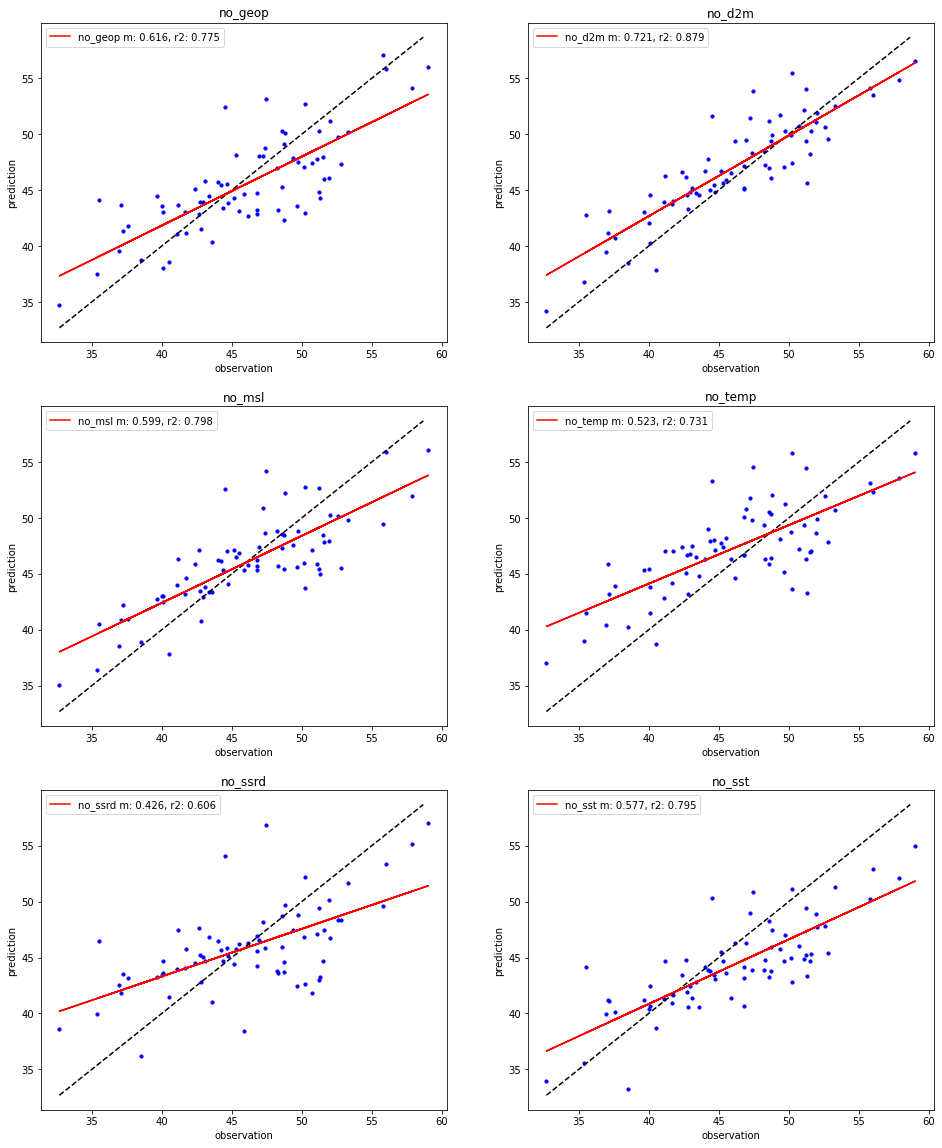

In [203]:
plot_region_scatters("North East", lon = [-105, -85], lat = [35, 50])

## Custom functions for fitting

In [9]:
import operator

def flatten_dataArray(dataArray):
    """Takes xr.DataArray and returns flattened numpy array with no NaNs"""
    
    array = dataArray.values.flatten()
    array = array[~np.isnan(array)]
    
    return array

def scipy_fit(obs_grid, var_grid):
    """fit observation grid to variable grid"""
    
    flat_obs = flatten_dataArray(obs_grid)
    flat_var = flatten_dataArray(var_grid)
    
    lingress = scipy.stats.linregress(flat_obs, flat_var)
    
    return lingress

In [10]:
fit_attrs = operator.attrgetter('slope', 'intercept', 'rvalue')

In [148]:
m, c, r = fit_attrs(scipy_fit(ozone.observation, ozone.all_features))

In [149]:
print(m, c, r)

0.7011838834232198 13.993139632145361 0.7500468484119666


In [138]:
vara

'no_sst'

In [141]:
getattr(ozone.mean(dim=['time']), var).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

# Group anaysis

How do the featureless models peform toghether

In [19]:
predictions = ozone.drop_vars(["observation", 'all_features'])
predictions

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 120, time: 460)
Coordinates:
  * time     (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2014-08-31
  * lon      (lon) float64 -180.0 -178.5 -177.0 -175.5 ... -6.0 -4.5 -3.0 -1.5
  * lat      (lat) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 64.5 66.0 67.5 69.0 70.5
Data variables:
    no_geop  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    no_d2m   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    no_msl   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    no_temp  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    no_ssrd  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    no_sst   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

Overly engineered code, trying to stick with the xarray readability. Much easier to just start with the numpy arrays from the start you dingus

In [20]:
featureless_average = xr.full_like(ozone.observation, fill_value=0)
featureless_error = xr.full_like(ozone.observation, fill_value=0)

In [22]:
from operator import attrgetter

In [39]:
# map(attrgetter('my_attr'), my_list)
# trial = np.array(list(map(attrgetter('values'), grids)))

### Routine for creating ensemble analysis

ensemble_average prediction

for time in ds:
    average grid and variance

In [23]:
# gets all the data variables of the dataset at once into a tuple
f = attrgetter(*list(predictions.data_vars))

featureless_average = []
featureless_error = []

for time in predictions.time:
    
    # selects dataset at specific time
    timed_grid_ds = predictions.sel(time = time)
    
    # gets all the data_variable grids at once into a list of xr.DataArrays
    grids = f(timed_grid_ds)
    
    # converts the xr.DataArray objects list to np.ndarray list
    grid_list = list(map(attrgetter('values'), grids))
        # attrgetter is a function which gets the 'values' attribute
        # this function has been mapped onto the grids list
        # then we convert this map back into a list
    
    # converts list to mega array and computes
    mega_array = np.array(grid_list)    
    mean = np.mean(mega_array, axis = 0)
    stddev = np.std(mega_array, axis = 0)
    
    featureless_average.append(mean)
    featureless_error.append(stddev)


In [24]:
# for plotting and Xarray coordinates
eralons = np.arange(-180, 0, 1.5)
eralats = np.arange(0, 72, 1.5)

time = pd.date_range('2010', '2015')
time = time[time.month.isin([6,7,8])]

dims_list = ['time', 'lat', 'lon']
coords_dict = coords = {'time' :  time,
                        'lat' : eralats,
                        'lon' : eralons}

def create_da(data):
    """ custom func, takes _data and returns xr.DataArray
    expecting shape (460, 48, 120, 1)
    """
    
    return xr.DataArray(data.squeeze(),
                        dims = dims_list,
                        coords = coords_dict)

In [25]:
featureless_average_da = create_da(np.array(featureless_average))
featureless_error_da = create_da(np.array(featureless_error))

In [26]:
featureless_ensemble = xr.Dataset({"average" : featureless_average_da,
                                   "stddev" : featureless_error_da})

featureless_ensemble = featureless_ensemble.where(ozone.observation>0)
featureless_ensemble

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 120, time: 460)
Coordinates:
  * time     (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2014-08-31
  * lat      (lat) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 64.5 66.0 67.5 69.0 70.5
  * lon      (lon) float64 -180.0 -178.5 -177.0 -175.5 ... -6.0 -4.5 -3.0 -1.5
Data variables:
    average  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    stddev   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [27]:
featureless_ensemble.to_netcdf("featureless_ensemble.nc")
# xr.load_dataset...

## Analysis

0.8442467639950895

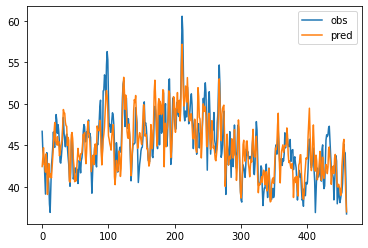

In [28]:
p = featureless_ensemble.average.mean(dim=['lat', 'lon'])
o = ozone.observation.mean(dim=['lat', 'lon'])

plt.plot(o, label = 'obs')
plt.plot(p, label = 'pred')
plt.legend()

np.corrcoef(o, p)[0,1]

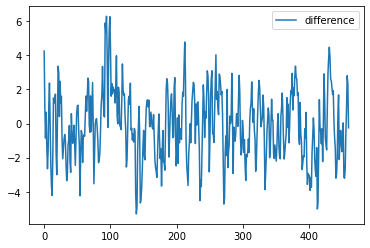

In [29]:
plt.plot(o-p, label = 'difference')
plt.legend()

AttributeError: 'function' object has no attribute 'fill_between'

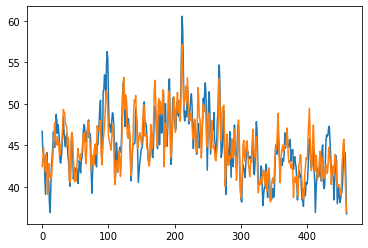

In [33]:
upper = featureless_ensemble.average + featureless_ensemble.stddev
lower = featureless_ensemble.average - featureless_ensemble.stddev

u = upper.mean(dim=['lat', 'lon'])
b = lower.mean(dim=['lat', 'lon'])

plt.plot(o)
plt.plot(p)
plt.plot.fill_between(np.arange(460), u, b)
# plt.plot(b)

In [90]:
def plot_usa() -> None:
    fig = plt.figure(figsize=(16,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.set_extent([-140, -60, 0, 60])
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True)
    
    return ax

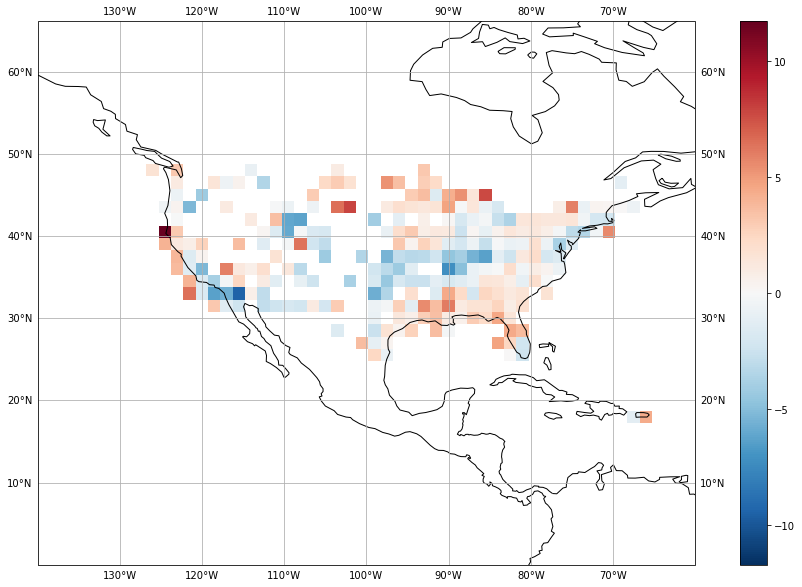

In [55]:
ax = plot_usa()

plt.title("Ensemble average difference from observation")
(featureless_ensemble.average.mean(dim=['time']) - ozone.observation.mean(dim=['time'])).plot(ax=ax)

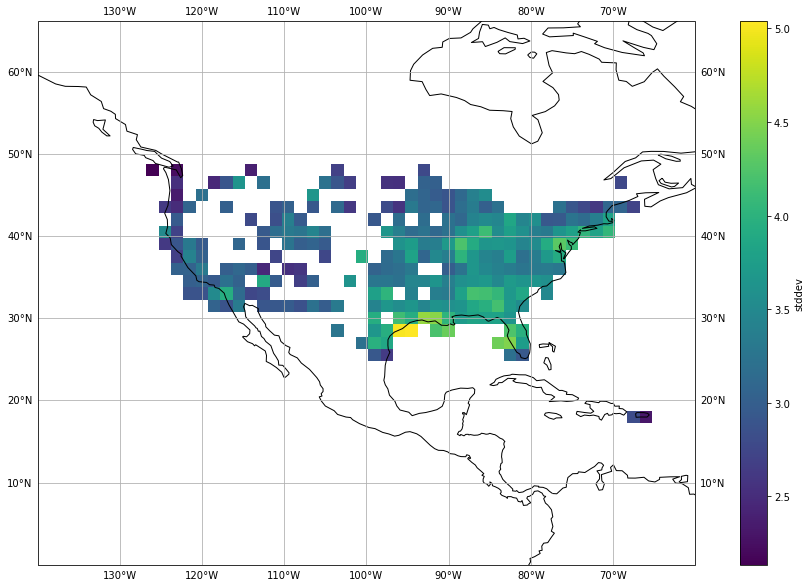

In [56]:
ax = plot_usa()
featureless_ensemble.stddev.mean(dim='time').plot(ax=ax)